In [ ]:
# from https://www.youtube.com/watch?v=JRlyw6LO5qo&t=130s

In [1]:
%pylab inline
import numpy as np
from tqdm import trange

Populating the interactive namespace from numpy and matplotlib


In [2]:
def fetch(url):
    import requests, gzip, os, hashlib, numpy
    fp = os.path.join("/tmp", hashlib.md5(url.encode('utf-8')).hexdigest())
    print(fp)
    if os.path.isfile(fp):
        with open(fp, "rb") as f:
            dat = f.read()
    else:
        with open(fp, "wb") as f:
            dat = requests.get(url).content
            f.write(dat)
    return numpy.frombuffer(gzip.decompress(dat), dtype=np.uint8).copy()


X_train = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_train = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]


/tmp/23278f029ff68f1e993776e500ce06b9
/tmp/d8b415e67abd11881e156b8f111d3300
/tmp/b0cdab8e37ae7c1c5560ee858afaac1d
/tmp/d4fdde61aca9f72d5fe2315410bb46a5


In [3]:
import torch
import torch.nn as nn
class BobNet(torch.nn.Module):
    def __init__(self):
        super(BobNet,self).__init__()
        self.l1 = nn.Linear(784,128)
        self.act = nn.ReLU()
        self.l2 = nn.Linear(128,10)
    def forward(self,x):
        x = self.l1(x)
        x = self.act(x)
        x = self.l2(x)
        return x


loss 0.19 accuracy 0.94: 100%|██████████| 1000/1000 [00:04<00:00, 211.26it/s]


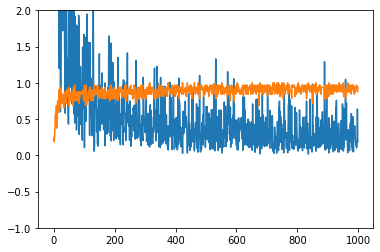

In [10]:
model = BobNet()
BS = 32
loss_function = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters())
losses, accuracies = [], []
t = trange(1000)
for i in t:
    samp = np.random.randint(0, X_train.shape[0], size=(BS))
    X = torch.tensor(X_train[samp].reshape(-1,28*28)).float()
    Y = torch.tensor(Y_train[samp]).long()
    optim.zero_grad()
    out = model(X)
    cat = torch.argmax(out, dim=1)
    accuracy = (cat == Y).float().mean()
    loss = loss_function(out, Y)
    loss.backward()
    optim.step()
    loss, accuracy = loss.item(), accuracy.item()
    losses.append(loss)
    accuracies.append(accuracy)
    t.set_description("loss %.2f accuracy %.2f" % (loss, accuracy))
plt.ylim(-1,2)
plot(losses)
plot(accuracies)

In [11]:
(Y_test == torch.argmax(model(torch.tensor(X_test.reshape(-1,28*28)).float()), dim=1).numpy()).mean()

0.9147

In [14]:
# copy weights from pytorch
l1 = model.l1.weight.detach().numpy().T
l2 = model.l2.weight.detach().numpy().T

# numpy forward pass
def forward(x):
    x = x.dot(l1)
    x = np.maximum(x, 0)
    x = x.dot(l2) 
    return x

def numpy_eval():
    Y_test_preds_out = forward(X_test.reshape((-1, 28*28)))
    Y_test_preds = np.argmax(Y_test_preds_out, axis=1)
    return (Y_test == Y_test_preds).mean()

numpy_eval()



0.9148

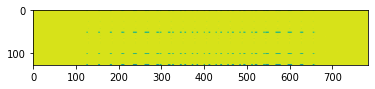

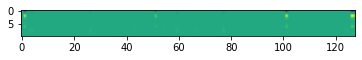

In [15]:
# numpy forward and backward pass

def logsumexp(x):
    #return np.log(np.exp(x).sum(axis=1))
    # http://gregorygundersen.com/blog/2020/02/09/log-sum-exp/
    c = x.max(axis=1)
    return c + np.log(np.exp(x-c.reshape((-1, 1))).sum(axis=1))

def forward_backward(x, y):
    # training
    out = np.zeros((len(y),10), np.float32)
    out[range(out.shape[0]),y] = 1

    # forward pass
    x_l1 = x.dot(l1)
    x_relu = np.maximum(x_l1, 0)
    x_l2 = x_relu.dot(l2)
    x_lsm = x_l2 - logsumexp(x_l2).reshape((-1, 1))
    x_loss = (-out * x_lsm).mean(axis=1)

    # training in numpy (super hard!)
    # backward pass

    # will involve x_lsm, x_l2, out, d_out and produce dx_sm
    d_out = -out / len(y)

    # derivative of logsoftmax
    # https://github.com/torch/nn/blob/master/lib/THNN/generic/LogSoftMax.c
    dx_lsm = d_out - np.exp(x_lsm)*d_out.sum(axis=1).reshape((-1, 1))

    # derivative of l2
    d_l2 = x_relu.T.dot(dx_lsm)
    dx_relu = dx_lsm.dot(l2.T)

    # derivative of relu
    dx_l1 = (x_relu > 0).astype(np.float32) * dx_relu

    # derivative of l1
    d_l1 = x.T.dot(dx_l1)
    
    return x_loss, x_l2, d_l1, d_l2

samp = [0,1,2,3]
x_loss, x_l2, d_l1, d_l2 = forward_backward(X_test[samp].reshape((-1, 28*28)), Y_test[samp])

imshow(d_l1.T)
figure()
imshow(d_l2.T)

loss 0.01 accuracy 0.98: 100%|██████████| 1000/1000 [00:04<00:00, 218.83it/s]


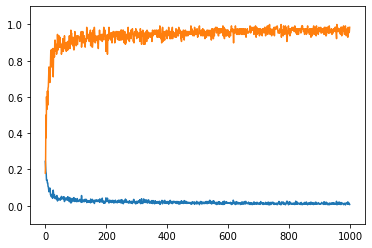

In [16]:
# numpy training
def layer_init(m, h):
    # gaussian is strong
    #ret = np.random.randn(m,h)/np.sqrt(m*h)
    # uniform is stronger
    ret = np.random.uniform(-1., 1., size=(m,h))/np.sqrt(m*h)
    return ret.astype(np.float32)

# reinit
np.random.seed(1337)
l1 = layer_init(784, 128)
l2 = layer_init(128, 10)

lr = 0.001
BS = 128
losses, accuracies = [], []
for i in (t := trange(1000)):
    samp = np.random.randint(0, X_train.shape[0], size=(BS))
    X = X_train[samp].reshape((-1, 28*28))
    Y = Y_train[samp]
    x_loss, x_l2, d_l1, d_l2 = forward_backward(X, Y)
    
    cat = np.argmax(x_l2, axis=1)
    accuracy = (cat == Y).mean()
    
    # SGD
    l1 = l1 - lr*d_l1
    l2 = l2 - lr*d_l2
    
    loss = x_loss.mean()
    losses.append(loss)
    accuracies.append(accuracy)
    t.set_description("loss %.2f accuracy %.2f" % (loss, accuracy))

plt.ylim(-0.1, 1.1)
plot(losses)
plot(accuracies)


In [17]:
numpy_eval()


0.9635